# Anomalieerkennung in Zeitreihen

Dieses Notebook nutzt eine One-class Support Vector Machine ([Implementierung von scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM)) zur Anomalieerkennung einer multivariaten Zeitreihe.

## Setup

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler

## Daten laden

Wir nutzen den Datensatz [Electric Motor Temperature](https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature/data) von der Universität Paderborn. Die Daten wurden zuvor von Kaggle geladen und liegen als `csv` Datei vor.

In [2]:
file_path = "datasets/multivariate_motor_temp/measures_v2.csv"

df = pd.read_csv(file_path)

# Hier wird festgelegt welche Spalten verwendet werden.
feature_columns = [
    'u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth', 
    'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque'
]

multivariate_data = df[feature_columns]


## Prüfung der Daten

Kurze Prüfung der Datenstruktur

In [3]:

print(multivariate_data.head())


        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197  


Einige statistische Informationen zur Verteilungung der Daten

In [4]:
print(multivariate_data.describe())

                u_q       coolant  stator_winding           u_d  stator_tooth  \
count  1.330816e+06  1.330816e+06    1.330816e+06  1.330816e+06  1.330816e+06   
mean   5.427900e+01  3.622999e+01    6.634275e+01 -2.513381e+01  5.687858e+01   
std    4.417323e+01  2.178615e+01    2.867206e+01  6.309197e+01  2.295223e+01   
min   -2.529093e+01  1.062375e+01    1.858582e+01 -1.315304e+02  1.813398e+01   
25%    1.206992e+01  1.869814e+01    4.278796e+01 -7.869090e+01  3.841601e+01   
50%    4.893818e+01  2.690014e+01    6.511013e+01 -7.429755e+00  5.603635e+01   
75%    9.003439e+01  4.985749e+01    8.814114e+01  1.470271e+00  7.558668e+01   
max    1.330370e+02  1.015985e+02    1.413629e+02  1.314698e+02  1.119464e+02   

        motor_speed           i_d           i_q            pm   stator_yoke  \
count  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06   
mean   2.202081e+03 -6.871681e+01  3.741278e+01  5.850678e+01  4.818796e+01   
std    1.859663e+03  6.493323e+01

### Visualisierung der Daten als Graphen

Bei der Visualisierung der Daten fällt auf, dass das Muster der Daten sich etwa ab der Hälfte (nach 600000 Reichen) deutlich ändert. Das muss bei der Auswertung beachtet werden.

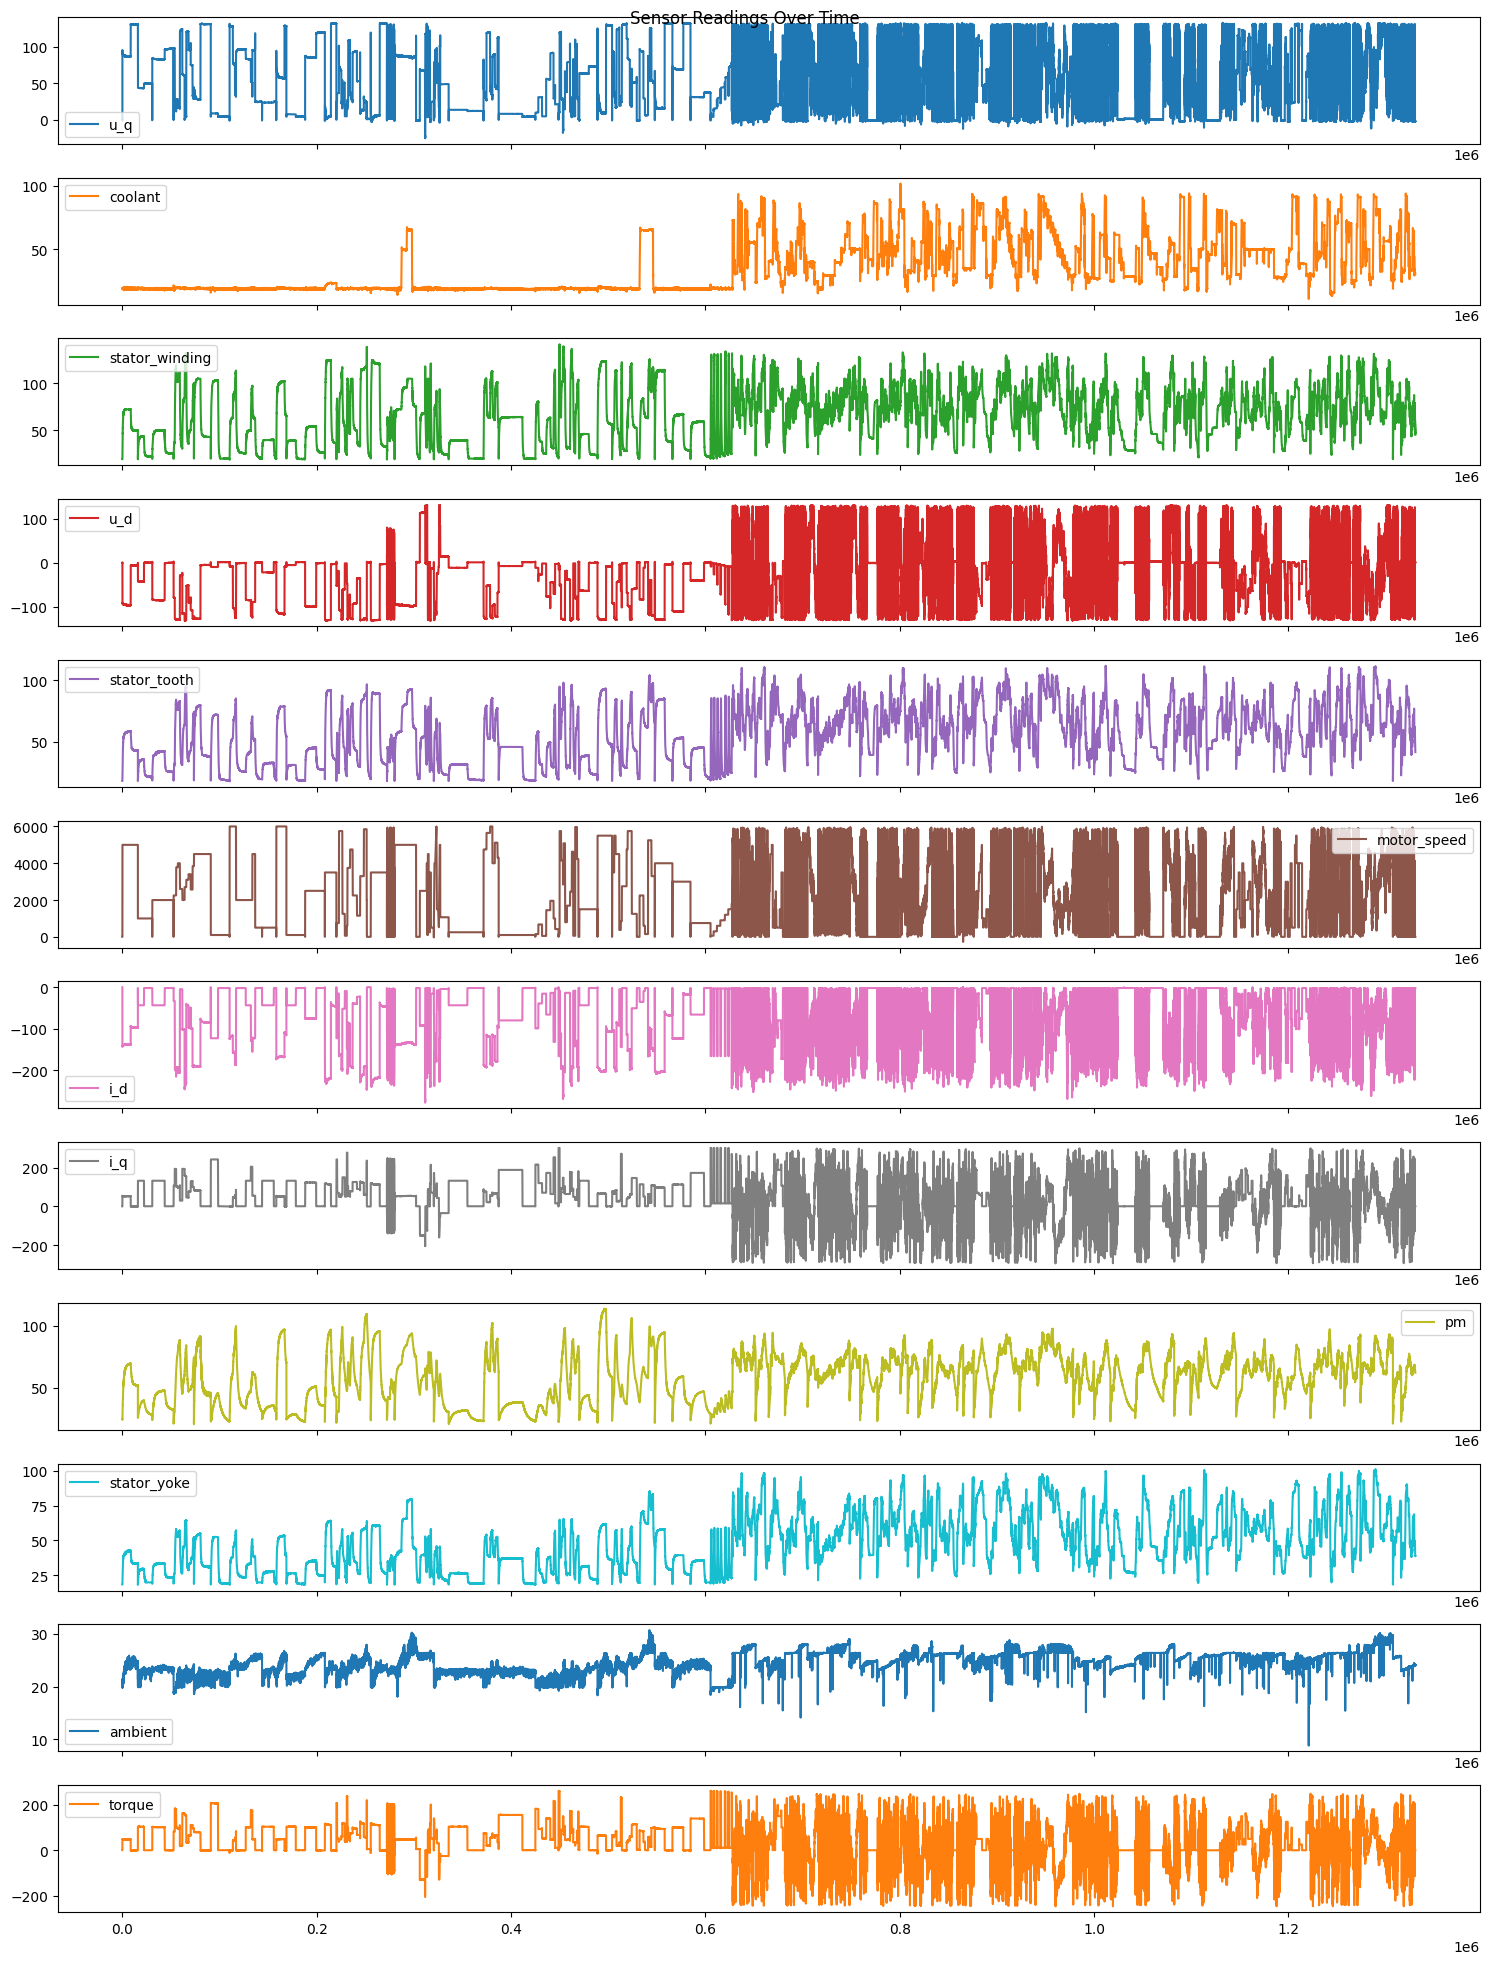

In [5]:
# Plot all feature columns to get a feel for the data
df[feature_columns].plot(subplots=True, figsize=(15, 20), title="Sensor Readings Over Time")
plt.tight_layout()
plt.show()

## Vorbereitung der Daten

Die Daten werden in die Trainingsphase und den Testphase geteilt und skaliert.

In [6]:

# Hier wird festgelegt wieviel Reihen für die Trainingsphase genutzt werden sollen.
TRAINING_ROWS = 150000
multivariate_data_training = multivariate_data.iloc[:TRAINING_ROWS]

# Für den nachfolgenden Test wird der ganze Datensatz verwendet
all_data_for_test = multivariate_data 

training_values = multivariate_data_training.values
all_values = all_data_for_test.values

In [7]:
scaler = MinMaxScaler()
training_values_scaled = scaler.fit_transform(training_values)
all_values_scaled = scaler.transform(all_values)

Das Modell soll nicht nur den Zusammenhang zwischen den Features finden, sondern auch Entwicklungen innerhalb der Zeitreihen berücksichtigen. Daher erhält das Modell nicht nur  einzelne Werte sondern jeweils Sequenzen von Einzelwerten als Input. Bei der multivariaten Analyse muss die Sequenzlänge aber gering gehalten werden, da die Berechnung in einem sehr hochdimensionalen Raum ansonsten zu viel Rechenleistung benötigt wird.

In [8]:
TIME_STEPS = 5 # Länge der Sequenzen

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    # Die Anzahl an Features wird praktisch als zusätzliche Dimension von 'values' hinzugefügt
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

X_train_3d = create_sequences(training_values_scaled)
X_test_3d = create_sequences(all_values_scaled)

# Die SVM erwartet einen 2D input (n_samples, n_features), deshalb muss das Array wieder abgeflacht werden
n_samples_train, n_timesteps, n_features = X_train_3d.shape
n_samples_test, _, _ = X_test_3d.shape

X_train_scaled = X_train_3d.reshape(n_samples_train, -1)
X_test_scaled = X_test_3d.reshape(n_samples_test, -1)

print("\nShape of 2D training data for SVM:", X_train_scaled.shape)
print("Shape of 2D test data for SVM:", X_test_scaled.shape)


Shape of 2D training data for SVM: (149996, 60)
Shape of 2D test data for SVM: (1330812, 60)


## Training

Hier definieren wir das Modell und trainieren es. Der Gammawert bestimmt wieviel einzelne Punkte sich im Training auf das Modell auswirken und der Paramerter nu bestimmt die "Glättung" der erlernten Kurve, also wie genau das Modell lernt die Trainingsdaten zu reproduzieren.

 [Dokumentation](https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel)

In [30]:
clf = OneClassSVM(nu=0.001, kernel='rbf', gamma=0.001)
clf.fit(X_train_scaled)

,kernel,'rbf'
,degree,3
,gamma,0.001
,coef0,0.0
,tol,0.001
,nu,0.001
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


## Inferenz

Nun kann das Modell auf den Rest der Daten angewandt werden.

In [31]:
# Vorhersage für alle Sequenzen generieren
x_pred_sequences = clf.predict(X_test_scaled)

# Vorhersagen zu den ursprünglichen Zeitpunkten zurückmappen als neue Spalte im Datensatz
x_pred_full = np.full(len(multivariate_data), 1, dtype=int)
x_pred_full[TIME_STEPS - 1:] = x_pred_sequences
multivariate_data['anomaly'] = x_pred_full

# Aufeinanderfolgende Anomalie-Punkte werden für die Auswertung gezählt
is_anomaly = multivariate_data['anomaly'] == -1
anomaly_blocks = (is_anomaly.diff() != 0).cumsum()
multivariate_data['consecutive_count'] = is_anomaly.groupby(anomaly_blocks).cumsum()

anomalies = multivariate_data[multivariate_data['consecutive_count'] > 0]


## Visualisierung der Ergebnisse

Aufeinanderfolgende Anomalien werden mit einer Farbskala dargestellt, um steigende Signifikanz der Anomalien zu symbolisieren.

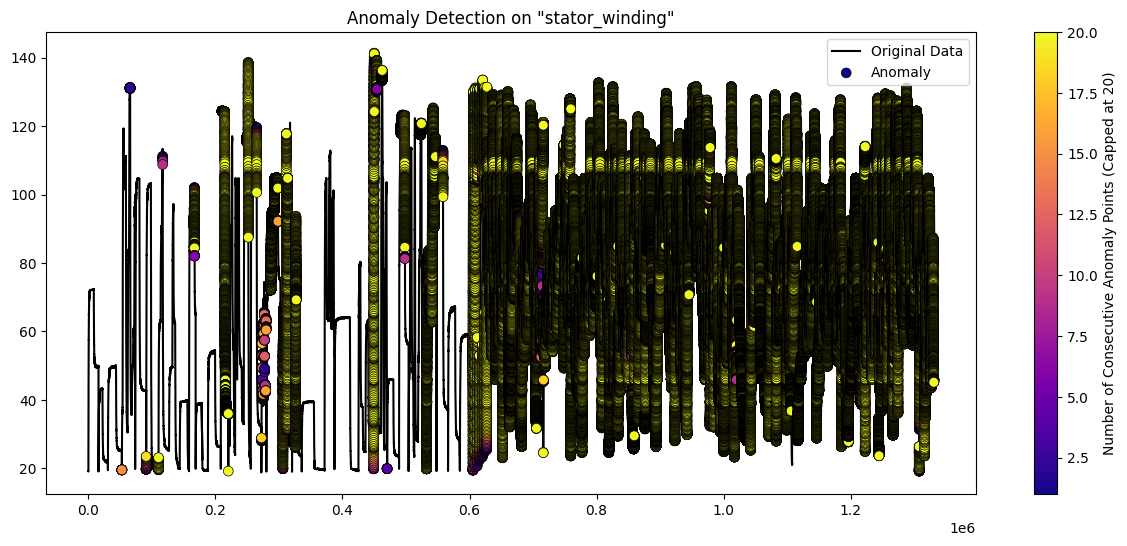

In [32]:
# Hier wird eine Spalte (Feature) gewählt gegen den die Anomalien geplottet werden
COLUMN_TO_PLOT = 'stator_winding'

# Für die Farbskala
COLORBAR_UPPER_LIMIT = 20
cmap = plt.colormaps['plasma']

fig, ax = plt.subplots(figsize=(15, 6))
multivariate_data[COLUMN_TO_PLOT].plot(legend=False, ax=ax, label='Original Data', color='black', zorder=1)

scatter = ax.scatter(
    anomalies.index, 
    anomalies[COLUMN_TO_PLOT], 
    c=anomalies['consecutive_count'], 
    cmap=cmap, 
    vmin=1,
    vmax=COLORBAR_UPPER_LIMIT,
    s=50,
    edgecolors='k',
    linewidths=0.5,
    label='Anomaly',
    zorder=2
)

plt.legend()
plt.title(f'Anomaly Detection on "{COLUMN_TO_PLOT}"')
cbar = fig.colorbar(scatter)
cbar.set_label(f'Number of Consecutive Anomaly Points (Capped at {COLORBAR_UPPER_LIMIT})')
plt.show()

Das Ergebnis ist in diesem Fall konsistent mit den Beobachtungen aus der eingangs betrachteten Visualisierung der Daten. Ab 0.6*1e6 Reihen ändert sich das Muster der Daten sehr deutlich, weshalb die meisten Datenpunkte ab diesem veränderten Muster als Anomalie markiert werden.